# 06. Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

In the previous two notebooks ([transfer learning part 1: feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb) and [part 2: fine-tuning](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb)) we've seen the power of transfer learning.

Now we know our smaller modelling experiments are working, it's time to step things up a notch with more data.

This is a common practice in machine learning and deep learning: get a model working on a small amount of data before scaling it up to a larger amount of data.

> 🔑 **Note:** You haven't forgotten the machine learning practitioners motto have you? "Experiment, experiment, experiment."

It's time to get closer to our Food Vision project coming to life. In this notebook we're going to scale up from using 10 classes of the Food101 data to using all of the classes in the Food101 dataset.

Our goal is to **beat the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)'s results with 10% of data**.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-ml-serial-experimentation.png)
*Machine learning practitioners are serial experimenters. Start small, get a model working, see if your experiments work then gradually scale them up to where you want to go (we're going to be looking at scaling up throughout this notebook).*

## What we're going to cover

We're going to go through the follow with TensorFlow:

- Downloading and preparing 10% of the Food101 data (10% of training data)
- Training a feature extraction transfer learning model on 10% of the Food101 training data
- Fine-tuning our feature extraction model
- Saving and loaded our trained model
- Evaluating the performance of our Food Vision model trained on 10% of the training data
  - Finding our model's most wrong predictions
- Making predictions with our Food Vision model on custom images of food

##Helper functions


In [1]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-12 21:32:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-12 21:32:39 (98.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

So far we've confirmed the transfer learning model's we've been using work pretty well with the 10 Food Classes dataset. Now it's time to step it up and see how they go with the full 101 Food Classes.

In the original [Food101](https://www.kaggle.com/dansbecker/food-101) dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

##Downloading the Data

In [3]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-01-12 21:32:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   197MB/s    in 6.7s    

2022-01-12 21:32:49 (233 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
#How many images are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/croque_madame'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/filet_mignon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/strawberry_shortcake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bread_pudding'.
There are 0 directories and 250 images in

In [5]:
#Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode = 'categorical',
                                                                 image_size = IMG_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Wonderful! It looks like our data has been imported as expected with 75 images per class in the training set (75 images * 101 classes = 7575 images) and 25250 images in the test set (250 images * 101 classes = 25250 images). 


## Train a big dog model with transfer learning on 10% of 101 food classes

Our food image data has been imported into TensorFlow, time to model it.

To keep our experiments swift, we're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

More specifically, our goal will be to see if we can beat the baseline from original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) (50.76% accuracy on 101 classes) with 10% of the training data and the following modelling setup:
* A [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
* Data augmentation built right into the model
* A headless (no top layers) [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) architecture from `tf.keras.applications` as our base model
* A `Dense` layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
* Categorical crossentropy as the loss function since we're dealing with more than two classes
* The Adam optimizer with the default settings
* Fitting for 5 full passes on the training data while evaluating on 15% of the test data

It seems like a lot but these are all things we've covered before in the [Transfer Learning in TensorFlow Part 2: Fine-tuning notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb).

Let's start by creating the `ModelCheckpoint` callback. 

Since we want our model to perform well on unseen data we'll set it to monitor the validation accuracy metric and save the model weights which score the best on that.

In [6]:
#Create the ModelCheckpoint path
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True, # save only the model weights
                                                         monitor = "val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only = True) # only keep the best model weights on file (delete the rest)

In [7]:
#Creating augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),                            
], name = "data_aug")

In [8]:
#Set up EfficientNetB0 as base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#Setup model architecture with trainable top layers
inputs = layers.Input(shape = (224, 224, 3), name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training = False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name = "global_average_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


Model method can take in the bottom layer: `inputs`, and the top layer: `outputs`. This requires all layers to be connected.

Layers are connected through the x variable. The connection is more simply points to the next layer. For example, `data_augmentation(inputs)` tells the model that data takes in the results of `inputs` layer. It is assigned to variable `x`, so it can be used to connect to the next layer. All layers need to be assigned to a variable.

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_aug (Sequential)       (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

[Output and Input layers of CNN](https://towardsdatascience.com/understanding-input-and-output-shapes-in-convolution-network-keras-f143923d56ca)

We are using global average pooling since it can reduce dimensions just like Flattening. REMEMBER, the first number in the output shape is the batch size. Flattening will not affect batch size, so it will also output a 2D tensor, just like global average pooling. However, pooling and flattening do different things. 

In [10]:
"""
#Just for experiementation
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#Setup model architecture with trainable top layers
inputs = layers.Input(shape = (224, 224, 3), name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training = False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.Flatten()(x)

outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", input_shape = [1280], name = "output_layer")(x)
model_exp = tf.keras.Model(inputs, outputs)
"""

'\n#Just for experiementation\nbase_model = tf.keras.applications.EfficientNetB0(include_top = False)\nbase_model.trainable = False\n\n#Setup model architecture with trainable top layers\ninputs = layers.Input(shape = (224, 224, 3), name = \'input_layer\')\nx = data_augmentation(inputs)\nx = base_model(x, training = False) # put the base model in inference mode so we can use it to extract features without updating the weights\nx = layers.Flatten()(x)\n\noutputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", input_shape = [1280], name = "output_layer")(x)\nmodel_exp = tf.keras.Model(inputs, outputs)\n'

[Why it doesn't work](https://stackoverflow.com/questions/56918388/error-valueerror-the-last-dimension-of-the-inputs-to-dense-should-be-defined)

Could be solved by using sequential model, using a pooling layer, or by defining the shape (not sure how though)

In [11]:
#Compile model
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

#Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15 * len(test_data)),
                                           callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 91s 323ms/step - loss: 3.4696 - accuracy: 0.2471 - val_loss: 2.6873 - val_accuracy: 0.4150
Epoch 2/5
237/237 [==============================] - 61s 257ms/step - loss: 2.3470 - accuracy: 0.4638 - val_loss: 2.2779 - val_accuracy: 0.4592
Epoch 3/5
237/237 [==============================] - 56s 236ms/step - loss: 1.9825 - accuracy: 0.5333 - val_loss: 2.1194 - val_accuracy: 0.4701
Epoch 4/5
237/237 [==============================] - 52s 217ms/step - loss: 1.7606 - accuracy: 0.5790 - val_loss: 2.0251 - val_accuracy: 0.4838
Epoch 5/5
237/237 [==============================] - 50s 210ms/step - loss: 1.5973 - accuracy: 0.6100 - val_loss: 1.9464 - val_accuracy: 0.4997


In [12]:
#Evaluate model on all of the test data
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 63s 79ms/step - loss: 1.7136 - accuracy: 0.5522


[1.7136269807815552, 0.5522376298904419]

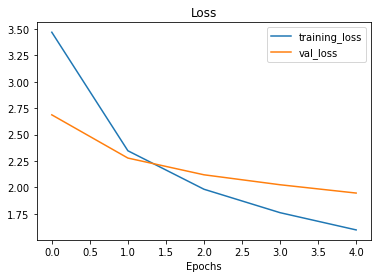

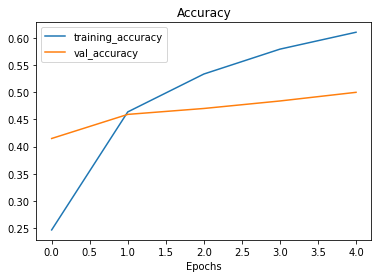

In [13]:
#Plot loss curves
plot_loss_curves(history_all_classes_10_percent)

It seems that the model is overfitting or underfitting

### Fine-tuning

Our feature extraction transfer learning model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements?

The good news is, thanks to the `ModelCheckpoint` callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its `trainable` attribute to `True`, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [14]:
#Unfreeze all of the layers
base_model.trainable = True

#refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

We just made a change to the layers in our model and what do we have to do every time we make a change to our model?

Recompile it.

Because we're fine-tuning, we'll use a 10x lower learning rate to ensure the updates to the previous trained weights aren't too large.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-lowering-the-learning-rate.png)
*When fine-tuning and unfreezing layers of your pre-trained model, it's common practice to lower the learning rate you used for your feature extraction model. How much by? A 10x lower learning rate is usually a good place to to start.*

In [15]:
#Recompile the mdoel with lower learning rate
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

In [16]:
!nvidia-smi

Wed Jan 12 21:41:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    45W /  70W |   4330MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
#Make sure layers are trainabel
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_aug True
efficientnetb0 True
global_average_pooling True
output_layer True


In [18]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [19]:
#Finetuning off of where the feature extraction model left off using teh initial_epoch param
fine_tune_epochs = 10 #already did 5 epochs
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 55s 203ms/step - loss: 1.3569 - accuracy: 0.6471 - val_loss: 1.9195 - val_accuracy: 0.4981
Epoch 6/10
237/237 [==============================] - 45s 187ms/step - loss: 1.2363 - accuracy: 0.6760 - val_loss: 1.9058 - val_accuracy: 0.5040
Epoch 7/10
237/237 [==============================] - 43s 181ms/step - loss: 1.1521 - accuracy: 0.6932 - val_loss: 1.9151 - val_accuracy: 0.5029
Epoch 8/10
237/237 [==============================] - 40s 168ms/step - loss: 1.0814 - accuracy: 0.7126 - val_loss: 1.9368 - val_accuracy: 0.4968
Epoch 9/10
237/237 [==============================] - 40s 168ms/step - loss: 1.0250 - accuracy: 0.7288 - val_loss: 1.9025 - val_accuracy: 0.5095
Epoch 10/10
237/237 [==============================] - 39s 161ms/step - loss: 0.9723 - accuracy: 0.7431 - val_loss: 1.9425 - val_accuracy: 0.5064


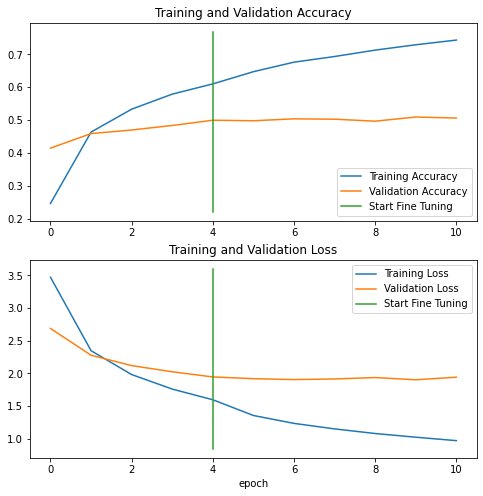

In [20]:
#Comparing histories
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit. 

This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, `EfficientNetB0` was trained on [ImageNet](http://www.image-net.org/index) which contains many real life pictures of food just like our food dataset.

If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

### Saving our trained model

To prevent having to retrain our model from scratch, let's save it to file using the [`save()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save) method.

In [21]:
'''#Save model to drive
model.save("drive/MyDrive/101_food_class_10_percent_saved_big_dog_model")'''

'#Save model to drive\nmodel.save("drive/MyDrive/101_food_class_10_percent_saved_big_dog_model")'

Cannot save due to the data aug layers

## Evaluating the performance of the big dog model across all different classes

We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.

But metrics schmetrics, let's dive a little deeper into our model's performance and get some visualizations going.

To do so, we'll load in the saved model and use it to make some predictions on the test dataset.

> 🔑 **Note:** Evaluating a machine learning model is as important as training one. Metrics can be deceiving. You should always visualize your model's performance on unseen data to make sure you aren't being fooled good looking training numbers.

In [22]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
#saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
#unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
# model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

### Making predictions with our trained model

To evaluate our trained model, we need to make some predictions with it and then compare those predictions to the test dataset.

Because the model has never seen the test dataset, this should give us an indication of how the model will perform in the real world on data similar to what it has been trained on.

To make predictions with our trained model, we can use the `predict()` method passing it the test data.

Since our data is multi-class, doing this will return a prediction probably tensor for each sample.

In other words, every time the trained model see's an image it will compare it to all of the patterns it learned during training and return an output for every class (all 101 of them) of how likely the image is to be that class.

In [23]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

790/790 [==============================] - 64s 79ms/step


In [24]:
#shape of predictions
pred_probs.shape

(25250, 101)

In [25]:
# How do they look?
pred_probs[:10]

array([[2.8264931e-01, 6.3347965e-05, 2.8319135e-01, ..., 2.9021488e-05,
        6.8950618e-04, 5.1148869e-02],
       [9.2597812e-01, 2.1373408e-07, 2.0336984e-03, ..., 8.7317760e-04,
        1.8387649e-06, 3.9660963e-06],
       [3.9675355e-01, 2.9885957e-03, 1.1780076e-02, ..., 5.3797005e-04,
        9.3392108e-04, 1.8860488e-03],
       ...,
       [5.7131624e-01, 2.8207144e-06, 7.6741172e-04, ..., 6.7109883e-02,
        5.7127012e-04, 1.2948345e-04],
       [1.9693264e-01, 1.0135662e-03, 1.8194665e-01, ..., 2.2690346e-04,
        1.8302952e-04, 4.4728222e-04],
       [5.1688999e-01, 2.2757258e-06, 2.1074675e-03, ..., 8.5230824e-03,
        6.2883128e-06, 5.3125364e-03]], dtype=float32)

In [26]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [2.82649308e-01 6.33479649e-05 2.83191353e-01 5.28426263e-08
 4.75865181e-06 1.41783198e-06 2.51890451e-05 1.06231491e-05
 1.17864693e-02 2.71846657e-04 3.36373864e-06 7.48638922e-06
 1.10337674e-03 1.30390788e-06 1.03235543e-02 8.60161672e-04
 1.48854097e-05 2.34571213e-04 2.10169330e-03 3.98406792e-06
 1.32675763e-04 2.86360118e-05 1.56897659e-04 1.39319221e-04
 7.98325462e-04 5.95981430e-04 9.04402987e-04 3.05478025e-05
 1.36925608e-01 1.83410884e-03 8.05502714e-06 6.65616419e-04
 9.79413162e-04 1.97765388e-07 1.13934223e-02 1.49534499e-05
 1.11779926e-04 9.84741375e-04 3.13315690e-02 1.29941363e-05
 4.43446479e-04 1.67850766e-03 6.13220967e-04 8.66398841e-06
 2.04177650e-05 1.89489001e-05 9.47572116e-04 1.50416046e-04
 6.93270692e-07 3.24734971e-02 1.28358079e-03 1.66793616e-05
 5.66149950e-02 3.74284154e-03 5.80904052e-05 1.00178681e-02
 7.62208970e-03 7.10609660e-04 2.91659357e-

As we discussed before, for each image tensor we pass to our model, because of the number of output neurons and activation function in the last layer (`layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax"`), it outputs a prediction probability between 0 and 1 for all each of the 101 classes.

And the index of the highest prediction probability can be considered what the model thinks is the most likely label. Similarly, the lower prediction probaiblity value, the less the model thinks that the target image is that specific class.

> 🔑 **Note:** Due to the nature of the softmax activation function, the sum of each of the prediction probabilities for a single sample will be 1 (or at least very close to 1). E.g. `pred_probs[0].sum() = 1`.

We can find the index of the maximum value in each prediction probability tensor using the `argmax()` method.

In [27]:
#Get the class prediction of each label
pred_classes = pred_probs.argmax(axis = 1)

#How do they look?
pred_classes[:10]

array([ 2,  0,  0, 38, 29, 78, 29,  0,  9,  0])

Beautiful! We've now got the predicted class index for each of the samples in our test dataset.

We'll be able to compare these to the test dataset labels to further evaluate our model.

To get the test dataset labels we can unravel our `test_data` object (which is in the form of a `tf.data.Dataset`) using the [`unbatch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch) method.

Doing this will give us access to the images and labels in the test dataset. Since the labels are in one-hot encoded format, we'll take use the `argmax()` method to return the index of the label.

> 🔑 **Note:** This unravelling is why we `shuffle=False` when creating the test data object. Otherwise, whenever we loaded the test dataset (like when making predictions), it would be shuffled every time, meaning if we tried to compare our predictions to the labels, they would be in different orders.

In [28]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [29]:
len(y_labels)

25250

### Evaluating our models predictions

A very simple evaluation is to use Scikit-Learn's [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function which compares truth labels to predicted labels and returns an accuracy score.

If we've created our `y_labels` and `pred_classes` arrays correctly, this should return the same accuracy value (or at least very close) as the `evaluate()` method we used earlier.

In [30]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5794059405940594

In [31]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [32]:
# Get the class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

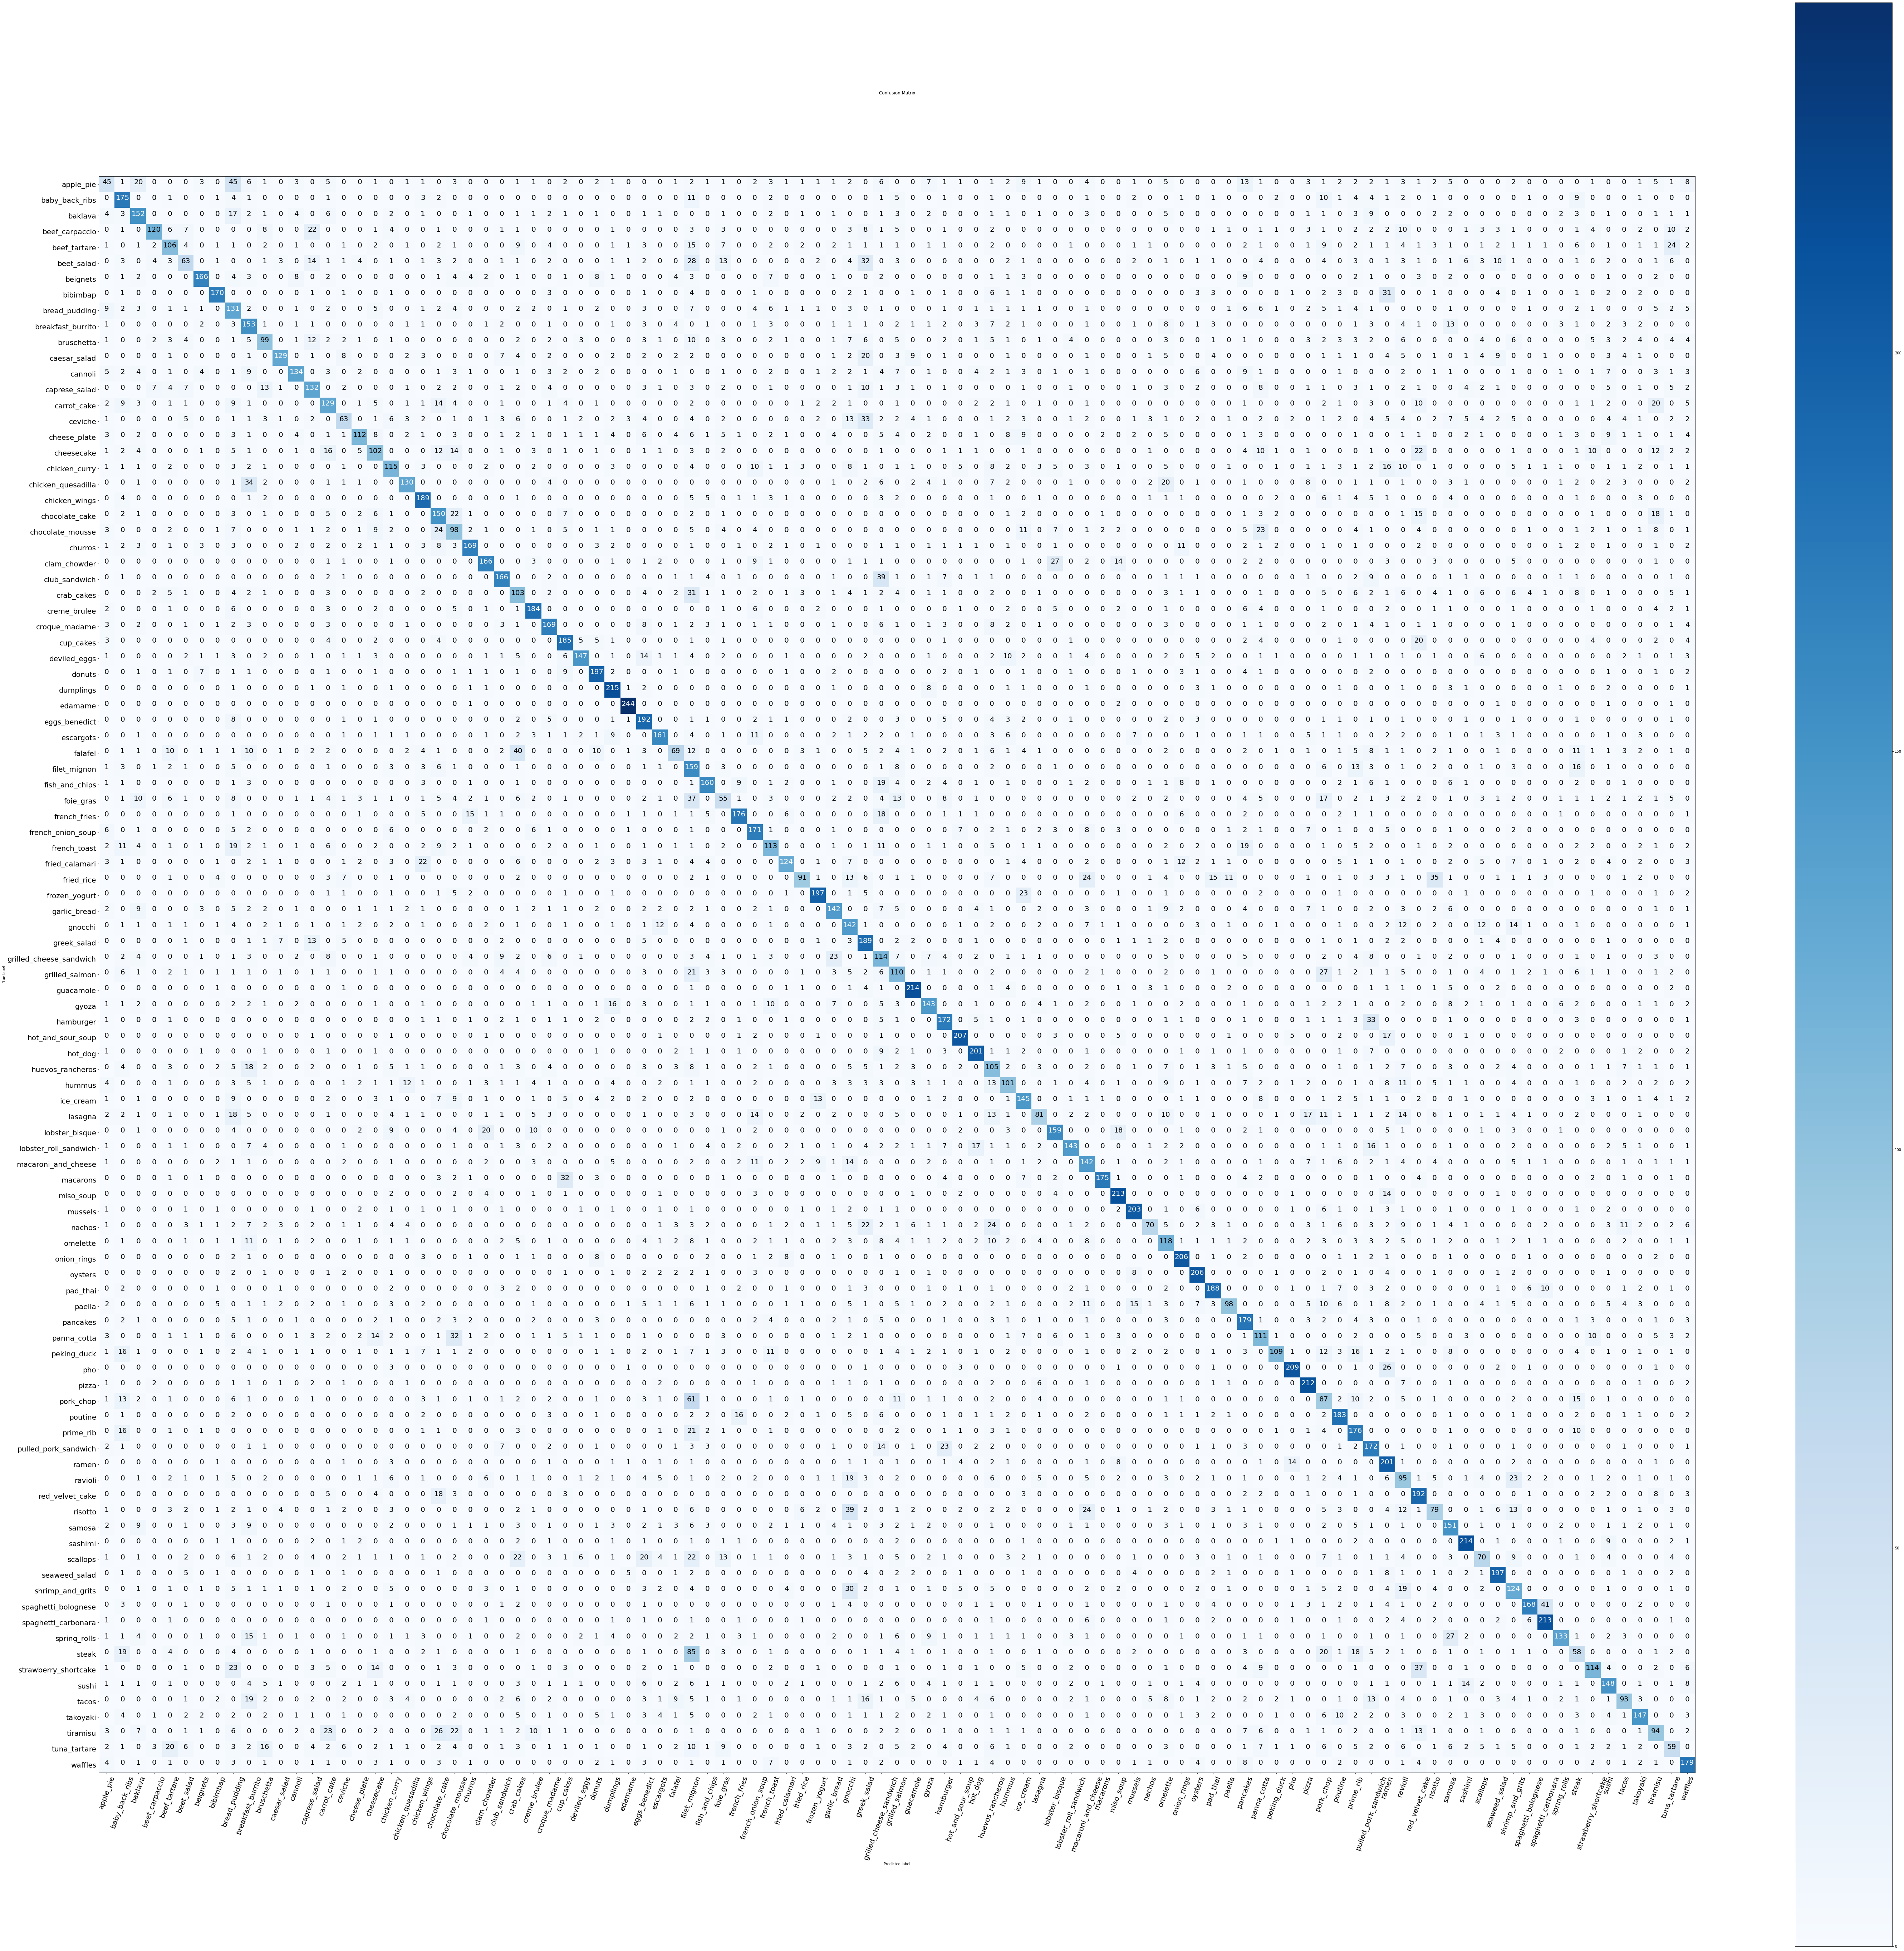

In [33]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

Woah! Now that's a big confusion matrix. It may look a little daunting at first but after zooming in a little, we can see how it gives us insight into which classes its getting "confused" on.

The good news is, the majority of the predictions are right down the top left to bottom right diagonal, meaning they're correct.

It looks like the model gets most confused on classes which look visualually similar, such as predicting `filet_mignon` for instances of `pork_chop` and `chocolate_cake` for instances of `tiramisu`.

Since we're working on a classification problem, we can further evaluate our model's predictions using Scikit-Learn's [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function.

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.31      0.18      0.23       250
           1       0.54      0.70      0.61       250
           2       0.57      0.61      0.59       250
           3       0.83      0.48      0.61       250
           4       0.51      0.42      0.46       250
           5       0.48      0.25      0.33       250
           6       0.81      0.66      0.73       250
           7       0.83      0.68      0.75       250
           8       0.29      0.52      0.37       250
           9       0.41      0.61      0.49       250
          10       0.52      0.40      0.45       250
          11       0.81      0.52      0.63       250
          12       0.77      0.54      0.63       250
          13       0.54      0.53      0.54       250
          14       0.48      0.52      0.50       250
          15       0.47      0.25      0.33       250
          16       0.71      0.45      0.55       250
          17       0.49    

The `classification_report()` outputs the precision, recall and f1-score's per class.

A reminder:
* **Precision** - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
* **Recall** - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
* **F1 score** - Combines precision and recall into one metric. 1 is best, 0 is worst.

The above output is helpful but with so many classes, it's a bit hard to understand.

Let's see if we make it easier with the help of a visualization.

First, we'll get the output of `classification_report()` as a dictionary by setting `output_dict=True`.

In [35]:
#Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict = True)
classification_report_dict

{'0': {'f1-score': 0.22900763358778628,
  'precision': 0.3146853146853147,
  'recall': 0.18,
  'support': 250},
 '1': {'f1-score': 0.607638888888889,
  'precision': 0.5368098159509203,
  'recall': 0.7,
  'support': 250},
 '10': {'f1-score': 0.4479638009049774,
  'precision': 0.515625,
  'recall': 0.396,
  'support': 250},
 '100': {'f1-score': 0.647377938517179,
  'precision': 0.5907590759075908,
  'recall': 0.716,
  'support': 250},
 '11': {'f1-score': 0.6308068459657702,
  'precision': 0.8113207547169812,
  'recall': 0.516,
  'support': 250},
 '12': {'f1-score': 0.6305882352941177,
  'precision': 0.7657142857142857,
  'recall': 0.536,
  'support': 250},
 '13': {'f1-score': 0.5354969574036511,
  'precision': 0.5432098765432098,
  'recall': 0.528,
  'support': 250},
 '14': {'f1-score': 0.5000000000000001,
  'precision': 0.4849624060150376,
  'recall': 0.516,
  'support': 250},
 '15': {'f1-score': 0.328125,
  'precision': 0.4701492537313433,
  'recall': 0.252,
  'support': 250},
 '16': {

Alright, there's still a fair few values here, how about we narrow down? 

Since the f1-score combines precision and recall in one metric, let's focus on that.

To extract it, we'll create an empty dictionary called `class_f1_scores` and then loop through each item in `classification_report_dict`, appending the class name and f1-score as the key, value pairs in `class_f1_scores`.

In [36]:
#Create empty dictionary
class_f1_scores = {}
#Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    #Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.22900763358778628,
 'baby_back_ribs': 0.607638888888889,
 'baklava': 0.5891472868217055,
 'beef_carpaccio': 0.6091370558375634,
 'beef_tartare': 0.4649122807017544,
 'beet_salad': 0.33070866141732286,
 'beignets': 0.7296703296703297,
 'bibimbap': 0.7456140350877193,
 'bread_pudding': 0.37321937321937326,
 'breakfast_burrito': 0.4911717495987159,
 'bruschetta': 0.4479638009049774,
 'caesar_salad': 0.6308068459657702,
 'cannoli': 0.6305882352941177,
 'caprese_salad': 0.5354969574036511,
 'carrot_cake': 0.5000000000000001,
 'ceviche': 0.328125,
 'cheese_plate': 0.5490196078431373,
 'cheesecake': 0.44541484716157204,
 'chicken_curry': 0.48319327731092443,
 'chicken_quesadilla': 0.6117647058823529,
 'chicken_wings': 0.7065420560747664,
 'chocolate_cake': 0.528169014084507,
 'chocolate_mousse': 0.37333333333333335,
 'churros': 0.7206823027718551,
 'clam_chowder': 0.6916666666666668,
 'club_sandwich': 0.6902286902286903,
 'crab_cakes': 0.3821892393320964,
 'creme_brulee': 0.73

Looking good!

It seems like our dictionary is ordered by the class names. However, I think if we're trying to visualize different scores, it might look nicer if they were in some kind of order.

How about we turn our `class_f1_scores` dictionary into a pandas DataFrame and sort it in ascending fashion?

In [37]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending = False)
f1_scores

class_name  f1-score
33            edamame  0.953125
75                pho  0.849593
54  hot_and_sour_soup  0.828000
51          guacamole  0.823077
86            sashimi  0.821497
..                ...       ...
77          pork_chop  0.307420
99       tuna_tartare  0.280285
39          foie_gras  0.270270
93              steak  0.260674
0           apple_pie  0.229008

[101 rows x 2 columns]

Now we're talking! Let's finish it off with a nice horizontal bar chart.


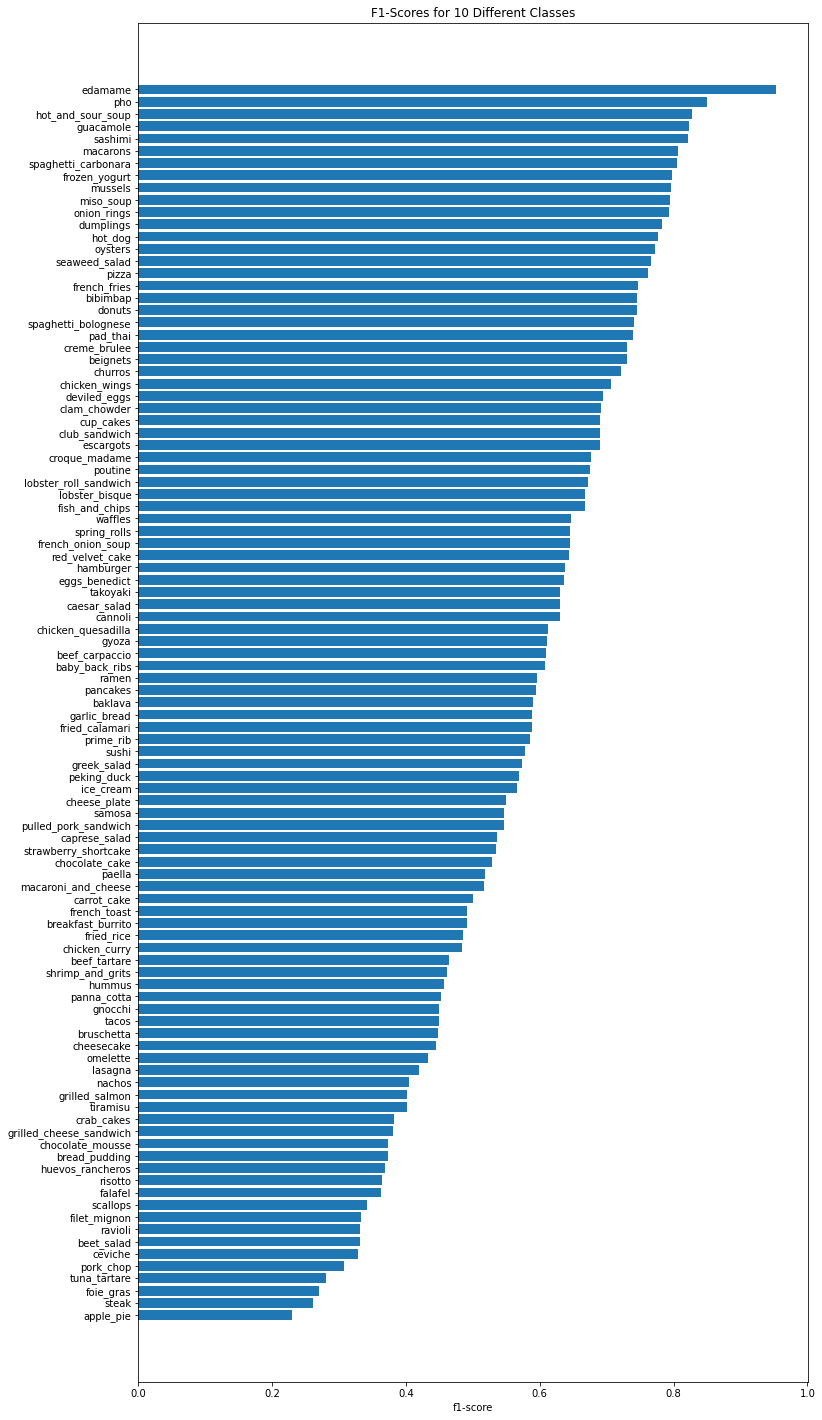

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

Now that's a good looking graph! I mean, the text positioning could be improved a little but it'll do for now.

Can you see how visualizing our model's predictions gives us a completely new insight into its performance?

A few moments ago we only had an accuracy score but now we've got an indiciation of how well our model is performing on a class by class basis.

It seems like our model performs fairly poorly on classes like `apple_pie` and `ravioli` while for classes like `edamame` and `pho` the performance is quite outstanding.

Findings like these give us clues into where we could go next with our experiments. Perhaps we may have to collect more data on poor performing classes or perhaps the worst performing classes are just hard to make predictions on.

### Visualizing predictions on test images

Time for the real test. Visualizing predictions on actual images. You can look at all the metrics you want but until you've visualized some predictions, you won't really know how your model is performing.

As it stands, our model can't just predict on any image of our choice. The image first has to be loaded into a tensor.

So to begin predicting on any given image, we'll create a function to load an image into a tensor.

Specifically, it'll:
* Read in a target image filepath using [`tf.io.read_file()`](https://www.tensorflow.org/api_docs/python/tf/io/read_file).
* Turn the image into a `Tensor` using [`tf.io.decode_image()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_image).
* Resize the image to be the same size as the images our model has been trained on (224 x 224) using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize).
* Scale the image to get all the pixel values between 0 & 1 if necessary.

In [39]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

Image loading and preprocessing function ready.

Now let's write some code to: 

1. Load a few random images from the test dataset.
2. Make predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

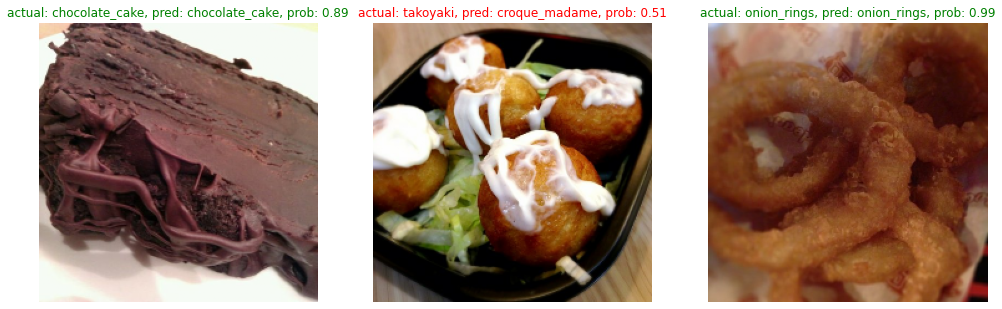

In [40]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Finding the most wrong predictions

It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These **most wrong** predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:
1. Get all of the image file paths in the test dataset using the [`list_files()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
  * **Note:** We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [41]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

Now we've got all of the test image filepaths, let's combine them into a DataFrame along with:
* Their ground truth labels (`y_labels`).
* The class the model predicted (`pred_classes`).
* The maximum prediction probabilitity value (`pred_probs.max(axis=1)`).
* The ground truth class names.
* The predicted class names. 

In [42]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  ...  y_pred_classname
0  b'101_food_classes_10_percent/test/apple_pie/1...  ...           baklava
1  b'101_food_classes_10_percent/test/apple_pie/1...  ...         apple_pie
2  b'101_food_classes_10_percent/test/apple_pie/1...  ...         apple_pie
3  b'101_food_classes_10_percent/test/apple_pie/1...  ...    fish_and_chips
4  b'101_food_classes_10_percent/test/apple_pie/1...  ...         cup_cakes

[5 rows x 6 columns]

In [43]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  ...  pred_correct
0  b'101_food_classes_10_percent/test/apple_pie/1...  ...         False
1  b'101_food_classes_10_percent/test/apple_pie/1...  ...          True
2  b'101_food_classes_10_percent/test/apple_pie/1...  ...          True
3  b'101_food_classes_10_percent/test/apple_pie/1...  ...         False
4  b'101_food_classes_10_percent/test/apple_pie/1...  ...         False

[5 rows x 7 columns]

And now since we know which predictions were right or wrong and along with their prediction probabilities, how about we get the 100 "most wrong" predictions by sorting for wrong predictions and descending prediction probabilties?

In [44]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  ...  pred_correct
23631  b'101_food_classes_10_percent/test/strawberry_...  ...         False
18001  b'101_food_classes_10_percent/test/pancakes/10...  ...         False
15826  b'101_food_classes_10_percent/test/macarons/19...  ...         False
23797  b'101_food_classes_10_percent/test/sushi/16593...  ...         False
5849   b'101_food_classes_10_percent/test/churros/254...  ...         False
17855  b'101_food_classes_10_percent/test/paella/2314...  ...         False
22511  b'101_food_classes_10_percent/test/spaghetti_b...  ...         False
10847  b'101_food_classes_10_percent/test/fried_calam...  ...         False
15425  b'101_food_classes_10_percent/test/lobster_rol...  ...         False
10854  b'101_food_classes_10_percent/test/fried_calam...  ...         False
21810  b'101_food_classes_10_percent/test/scallops/17...  ...         False
176    b'101_food_classes_10_percent/test/apple_pie/3...  ...         False
23935  b'101_food_classes_10_percent/test/sushi/46797...  ...         False
11642  b'101_food_classes_10_percent/test/garlic_brea...  ...         False
19521  b'101_food_classes_10_percent/test/poutine/132...  ...         False
14691  b'101_food_classes_10_percent/test/ice_cream/3...  ...         False
22     b'101_food_classes_10_percent/test/apple_pie/1...  ...         False
21216  b'101_food_classes_10_percent/test/risotto/493...  ...         False
9110   b'101_food_classes_10_percent/test/falafel/241...  ...         False
15304  b'101_food_classes_10_percent/test/lobster_rol...  ...         False

[20 rows x 7 columns]

Very interesting... just by comparing the ground truth classname (`y_true_classname`) and the prediction classname column (`y_pred_classname`), do you notice any trends?

It might be easier if we visualize them.

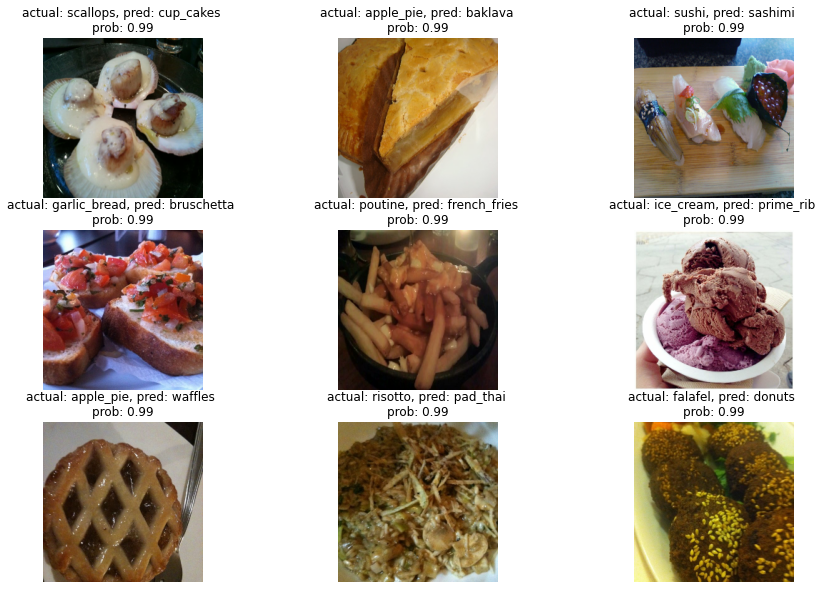

In [45]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

Going through the model's most wrong predictions can usually help figure out a couple of things:
* **Some of the labels might be wrong** - If our model ends up being good enough, it may actually learning to predict very well on certain classes. This means some images which the model predicts the right label may show up as wrong if the ground truth label is wrong. If this is the case, we can often use our model to help us improve the labels in our dataset(s) and in turn, potentially making future models better. This process of using the model to help improve labels is often referred to as [**active learning**](https://blog.scaleway.com/active-learning-some-datapoints-are-more-equal-than-others/).
* **Could more samples be collected?** - If there's a recurring pattern for a certain class being poorly predicted on, perhaps it's a good idea to collect more samples of that particular class in different scenarios to improve further models.

## Test out the big dog model on test images as well as custom images of food 

So far we've visualized some our model's predictions from the test dataset but it's time for the real test: using our model to make predictions on our own custom images of food.

For this you might want to upload your own images to Google Colab or by putting them in a folder you can load into the notebook.

In my case, I've prepared my own small dataset of six or so images of various foods.

Let's download them and unzip them.

In [46]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") 

--2022-01-12 21:49:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  39.8MB/s    in 0.3s    

2022-01-12 21:49:27 (39.8 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [47]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg']

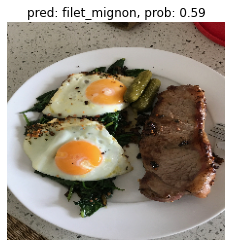

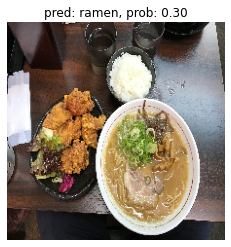

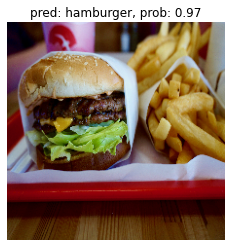

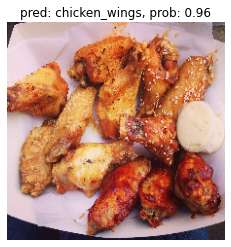

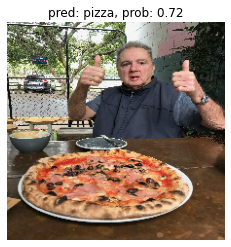

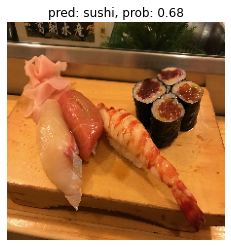

In [48]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

Two thumbs up! How cool is that?! Our Food Vision model has come to life!

Seeing a machine learning model work on a premade test dataset is cool but seeing it work on your own data is mind blowing.

And guess what... our model got these incredible results (10%+ better than the baseline) with only 10% of the training images.

I wonder what would happen if we trained a model with all of the data (100% of the training data from Food101 instead of 10%)? Hint: that's your task in the next notebook.